In [21]:
import cv2
import torch
import numpy as np

from PIL import Image
from ultralytics import YOLO


# load pose model
model=YOLO("yolov8m-pose.pt")
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

# results=model.track("data/box.mov",conf=0.1,show=True)

26.464462 million parameters


## Objective
We aim to track both bounding boxes and keypoints of human body. While tracking bounding box coordinates is integrated in yolov8, tracking keypoints is not. We will explore 2 ways in tracking the keypoints:
1. **Track keypoints** using the linear transformation (scaling + translation) that map the old box to the new box.
2. **Copy the keypoints**  from the last detection (in case no detection for the current frame).

### 1. Helper functions
We will implement 2 functions in this section
1. Draw keypoints 
2. Detect large objects 

In [ ]:
# Keypoints for human body

keypoints={0: "Nose", 1: "Left Eye", 2: "Right Eye", 3: "Left Ear", 4: "Right Ear",
           5: "Left Shoulder", 6: "Right Shoulder", 7: "Left Elbow", 8: "Right Elbow", 9: "Left Wrist", 10: "Right Wrist", 
           11: "Left Hip", 12: "Right Hip", 13: "Left Knee", 14: "Right Knee", 15: "Left Ankle", 16: "Right Ankle"}

# Lines between the keypoints
edges=[(0,1),(0,2),(1,2),(1,3),(2,4),
        (3,5),(4,6),(5,6),
        (5,7), (7,9), (6,8), (8,10), (5,11), (6,12), (11,12),
        (11,13),(12,14),(13,15),(14,16)
        ]



0: 384x640 1 person, 144.0ms
Speed: 2.5ms preprocess, 144.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


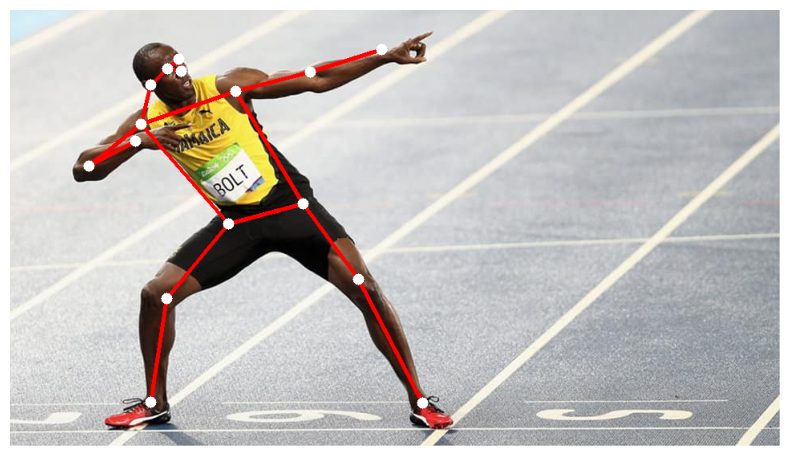

In [22]:
import matplotlib.pyplot as plt

# plot keypoints and their connectivity on image
def plot_keypoints(image, keypoints, show=False, edges=edges,keypoints_labels=None,save=False):
    """
    Plot keypoints and edges on image
    Arguments:
        keypoints = list of keypoint tensors [[x,y]]
        edges =     list [(start_keypoint,end_keypoint)]
    """
    
    image_copy=image.copy()
    
    for key_points in keypoints:

        # draw edge lines
        for edge in edges:

            # Ensure the edge indices are within the bounds of the keypoints array
            if edge[0] < len(key_points) and edge[1] < len(key_points):

                start_point=tuple(key_points[edge[0]].astype(int)) # (x_start,y_start)
                end_point=tuple(key_points[edge[1]].astype(int))   # (x_end, y_end)

                # handle the case keypoints are padded with (0,0) (not all keypoints are visible)
                if start_point != (0,0) and end_point!=(0,0):
                    cv2.line(image_copy,start_point,end_point,(0,0,255),3)              # red line
        
        # draw key points
        for idx,coordinates in enumerate(key_points):

            if tuple(coordinates)!=(0,0):
                cv2.circle(image_copy,tuple(coordinates.astype(int)),7,(255,255,255),-1) # white circle
                if keypoints_labels:
                    cv2.putText(image_copy,keypoints_labels[idx],
                                tuple(coordinates),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    if show:
        height, width=image_copy.shape[:2]
        ratio=height/width
        fig_size=(10,10*ratio)
        plt.figure(figsize=fig_size)
        plt.imshow(cv2.cvtColor(image_copy,cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    # save the image
    if save:
        cv2.imwrite("pose.jpg",image_copy)
    return image_copy

# sanity check
image=cv2.imread("data/athlete.jpg")

dets=model.predict(image,conf=0.5)
dets=dets[0]

keypoints=dets.keypoints.xy.cpu().numpy()
result=plot_keypoints(image, keypoints, show=True)


In [28]:
# detect large objects in an image     
def detect_large_keypoints(image_array,ratio=1/4,conf=0.1):
    """
        Return 2 lists: [xywh,conf,cls], keypoints_list
    """
    height,width=image_array.shape[:2]

    # prediction with yolo model
    dets=model.predict(image_array,conf=conf)
    dets=dets[0] # only 1 input image -> dets = list of length 1
    
    xywhs=dets.boxes.xywh.cpu().numpy()
    confs=dets.boxes.conf.cpu().numpy()
    clss=dets.boxes.cls.cpu().numpy()

    keypoints_list=dets.keypoints.xy.cpu().numpy()

    results,keypoints_list_results=[],[]

    for xywh,score,cls,keypoints in zip(xywhs,confs,clss,keypoints_list):

        if xywh[2]>width*ratio or xywh[3]>height*ratio:
            results.append([xywh[0],xywh[1],xywh[2],xywh[3],score,cls])
            keypoints_list_results.append(keypoints)    # keypoints = [17,2]
    
    return np.asarray(results), np.asarray(keypoints_list_results)

In [29]:
# input to BYTETracker = class instance with attributes xywh,conf,cls
class Result:
    def __init__(self,xywh,conf,cls):
        self.xywh=xywh
        self.conf=conf
        self.cls=cls

## 2. Track keypoints 

### (a) Update keypoints based on bounding-box movement
The new coordinates $(x'_1,y'_1, x'_2, y'_2)$ are obtained from the old ones $(x_1,y_1, x_2, y_2)$ by a translation + scaling. For any point $(x,y)$ in the old box, its cooresponding new coordinates are
\begin{align*}
x_{new}&= x'_1+r_x(x'_2-x'_1) \ \text{with} \ r_x = \dfrac{x-x_1}{x_2-x_1} \\
y_{new}&= y'_1+r_y(y'_2-y'_1) \ \text{with} \ r_y = \dfrac{y-y_1}{y_2-y_1} 
\end{align*}

In [30]:
# Update keypoints based on new and old bounding box coordinates
#        only transform keypoints that are detected by the model: not the point (0,0)
def transform_linear(old_boxes, new_boxes, keypoints_list):
    """
    return coordinates of new keypoints 
    args: old_boxes = old bbox coordinates in xyxy format
          new_boxes = new bbox coordinates in xyxy format
          keypoints_list= list of keypoint lists in old_boxes (each list for 1 box)
    """
    transform_keypoints_list=[]
    
    # loop through the boxes
    for old_box, new_box, keypoints in zip(old_boxes, new_boxes, keypoints_list):
        keypoints_transformed=[]

        # new keypoints and old keypoints
        x1,y1,x2,y2=old_box
        x1_new,y1_new,x2_new,y2_new=new_box
        
        # width and height of the new box
        width=x2_new-x1_new
        height=y2_new-y1_new
        measures=np.array([width,height])

        # offset of the bounding box transformation  
        offset=np.array([x1_new,y1_new])

        # loop through keypoints in a list
        for keypoint in keypoints:
            if list(keypoint) != [0,0]:
                x,y=keypoint
                # compute matrix of linear transformation
                r_x=(x-x1)/(x2-x1)
                r_y=(y-y1)/(y2-y1)
                matrix=np.diag([r_x,r_y])

                # get new coordinates
                keypoint_new=np.dot(matrix,measures)+offset
                keypoints_transformed.append(keypoint_new)

        transform_keypoints_list.append(keypoints_transformed)

    return transform_keypoints_list

### (b) Tracking Keypoints with ByteTrack

In [31]:
from argparse import Namespace
from ultralytics.trackers.byte_tracker import BYTETracker

def track_keypoints(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # video features
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Original width : {width} | Original height : {height} | num_frames : {num_frames}")

    # codec
    out = cv2.VideoWriter(video_path[:-4] + "_keypoints_tracked.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps//2, (width, height))
    
    history = {}         # {track_id: [bbox, keypoints_old, keypoints_new]}
    frame_history = {}   # {track_id: frame_number} with frame_number = most recent frame track_id is detected
    
    buffer = 30          # maximum number of frames to retain information
    MIN_BOXES = 2        # minimum number of boxes to draw in every frame 
    last_min_results = None # last result which detect at least 2 boxes

    # activate BYTETracker
    args = Namespace(track_high_thresh=0.5, track_low_thresh=0.1,
                     match_thresh=0.7, new_track_thresh=0.6,
                     track_buffer=buffer, fuse_score=True)
    tracker = BYTETracker(args, frame_rate=fps)
    
    # loop through frames
    frame_number = 0
    while frame_number < num_frames:
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame {frame_number}. Skipping...")
            frame_number += 1
            continue     
        
        # prediction on large objects from YOLOv8
        results, keypoints_list_old = detect_large_keypoints(frame)

        if len(results) < MIN_BOXES:
            results = last_min_results
        else:
            last_min_results = results
        
        # prepare input for tracker
        xywh = results[:, :4]       # old boxes in xywh format        
        conf = results[:, 4]
        cls = results[:, 5]
        tracker_inputs = Result(xywh, conf, cls)

        # track the frame: tracked_frame = [x1, y1, x2, y2, track_id, score, class, idx]
        tracked_frame = tracker.update(tracker_inputs)
        
        # old boxes: convert xywh->xyxy format
        old_boxes=np.asarray([[box[0]-box[2]/2,box[1]-box[3]/2, box[0]+box[2]/2,box[1]+box[3]/2] for box in xywh])

        # extract track results
        track_ids = tracked_frame[:, 4]
        new_boxes = tracked_frame[:, :4]    # new boxes in xyxy format
        

        # get new keypoints on new boxes
        keypoints_list_new=transform_linear(old_boxes=old_boxes,new_boxes=new_boxes,keypoints_list=keypoints_list_old)

        # Update the history with current track_id and bbox
        for track_id, bbox, keypoints_new in zip(track_ids, new_boxes,keypoints_list_new):
            history[track_id] = [bbox,keypoints_new]
            frame_history[track_id] = frame_number

        # remove track_ids and bboxes that were not seen in the last 30 frames
        for track_id in list(history.keys()):
            if frame_history[track_id] < frame_number - buffer:
                del history[track_id]
                del frame_history[track_id]

        # loop over track_id in history
        for track_id, (bbox,keypoints_new) in history.items():            
            # draw keypoints
            frame=plot_keypoints(image=frame,keypoints=[keypoints_new])
            
            # draw bbox and track_id
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, str(track_id), (int(bbox[0]), int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame)
        frame_number += 1
        
    cap.release()
    out.release()
    cv2.destroyAllWindows()

video_path = "data/box.mov"
track_keypoints(video_path)

Original width : 1920 | Original height : 1080 | num_frames : 196

0: 384x640 18 persons, 142.2ms
Speed: 4.2ms preprocess, 142.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 123.9ms
Speed: 1.5ms preprocess, 123.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 127.7ms
Speed: 1.4ms preprocess, 127.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 119.4ms
Speed: 1.7ms preprocess, 119.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 120.5ms
Speed: 1.6ms preprocess, 120.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 127.8ms
Speed: 1.5ms preprocess, 127.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 133.8ms
Speed: 1.8ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 

In [32]:
from argparse import Namespace
from ultralytics.trackers.byte_tracker import BYTETracker

def track_copy(video_path):
    cap = cv2.VideoCapture(video_path)

    # video features
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Original width : {width} | Original height : {height} | num_frames : {num_frames}")

    # codec
    out = cv2.VideoWriter(video_path[:-4] + "_keypoints_copy.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps//2, (width, height))
    
    history = {}         # dictionary {track_id: [bbox, keypoints_old]}
    frame_history = {}   # dictionary {track_id: frame_number} with frame_number = most recent frame track_id is detected
    
    buffer = 30          # maximum number of frames to retain information    
    MIN_BOXES = 2        # minimum number of boxes to draw in every frame 
    last_min_results = None # last result which detect at least 2 boxes

    # activate BYTETracker
    args = Namespace(track_high_thresh=0.5, track_low_thresh=0.1,
                     match_thresh=0.7, new_track_thresh=0.6,
                     track_buffer=buffer, fuse_score=True)
    tracker = BYTETracker(args, frame_rate=fps)
    
    # loop through frames
    frame_number = 0
    while frame_number < num_frames:
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame {frame_number}. Skipping...")
            frame_number += 1
            continue     
        
        # prediction on large objects from YOLO
        results, keypoints_list = detect_large_keypoints(frame)

        if len(results) < MIN_BOXES:
            results = last_min_results
        else:
            last_min_results = results
        
        # prepare input for tracker
        xywhs = results[:, :4]       # old boxes in xywh format        
        confs = results[:, 4]
        clss = results[:, 5]
        tracker_inputs = Result(xywhs, confs, clss)

        # track the frame: tracked_frame = [x1, y1, x2, y2, track_id, score, class, idx]
        tracked_frame = tracker.update(tracker_inputs)
        
        # extract track results
        track_ids = tracked_frame[:, 4]
        new_boxes = tracked_frame[:, :4]    # new boxes in xyxys format
        
        # Update the history with current track_id and bbox
        for track_id, bbox, keypoints in zip(track_ids, new_boxes,keypoints_list):
            history[track_id] = [bbox,keypoints]
            frame_history[track_id] = frame_number

        # remove track_ids and bboxes that were not seen in the last 30 frames
        for track_id in list(history.keys()):
            if frame_history[track_id] < frame_number - buffer:
                del history[track_id]
                del frame_history[track_id]

        # loop over track_id in history
        for track_id, (bbox,keypoints) in history.items():            
            # draw keypoints
            frame=plot_keypoints(image=frame,keypoints=[keypoints])
            
            # draw bbox and track_id
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, str(track_id), (int(bbox[0]), int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        out.write(frame)
        frame_number += 1
        
    cap.release()
    out.release()
    cv2.destroyAllWindows()

video_path = "data/box.mov"
track_copy(video_path)

Original width : 1920 | Original height : 1080 | num_frames : 196

0: 384x640 18 persons, 165.7ms
Speed: 2.8ms preprocess, 165.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 151.1ms
Speed: 2.5ms preprocess, 151.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 140.3ms
Speed: 1.8ms preprocess, 140.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 129.9ms
Speed: 1.8ms preprocess, 129.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 122.8ms
Speed: 1.6ms preprocess, 122.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 121.6ms
Speed: 1.5ms preprocess, 121.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 123.5ms
Speed: 1.7ms preprocess, 123.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 

### Comparison
Put 2 videos side by side for comparison

In [33]:
from moviepy.editor import VideoFileClip, clips_array

# Load the two video files
video1 = VideoFileClip("data/box_keypoints_copy.mp4")
video2 = VideoFileClip("data/box_keypoints_tracked.mp4")

# Resize videos to have the same height
height = min(video1.h, video2.h)
video1_resized = video1.resize(height=height)
video2_resized = video2.resize(height=height)

# Combine the videos side by side
final_video = clips_array([[video1_resized, video2_resized]])

# Export the final video
final_video.write_videofile("side_by_side_video.mp4", codec="libx264", fps=14)


Moviepy - Building video side_by_side_video.mp4.
Moviepy - Writing video side_by_side_video.mp4



Moviepy - Done !
Moviepy - video ready side_by_side_video.mp4
